# Time Series Demo: CDCV and MGC-TS
In this notebook, we demonstrate the cross-distance covariance (`cdcv`) test and the multiscale graph correlation time series (`mgc_ts`) test for independence of time series.

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

from mgcpy.independence_tests.cdcv import CDCV
from mgcpy.independence_tests.mgc_ts import MGC_TS

**Function to compute and print CDCV nd MGC_TS output values, given X and Y:**

In [2]:
def compute_cdcv(X, Y, max_lag):
    cdcv = CDCV(max_lag = max_lag, which_test = 'unbiased')
    cdcv_statistic, metadata = cdcv.test_statistic(X, Y)
    p_value, _ = cdcv.p_value(X, Y)
    optimal_lag = metadata['optimal_lag']

    print("CDCV test statistic:", cdcv_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    return cdcv_statistic, p_value, optimal_lag

def compute_mgc_ts(X, Y, max_lag, is_fast = False):
    mgc_ts = MGC_TS(max_lag = max_lag)
    mgc_ts_statistic, metadata = mgc_ts.test_statistic(X, Y, is_fast = is_fast)
    p_value, _ = mgc_ts.p_value(X, Y, is_fast = is_fast)
    optimal_lag = metadata['optimal_lag']
    
    print("MGC TS test statistic:", mgc_ts_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    return mgc_ts_statistic, p_value

**Example: simulate data `X` and `Y` in the form of `n`-by-`p` and `n`-by-`q` matrices respectively, where `n` is the sample size.** In the following cells, we simulate different time series processes and estimate the power of the test at varying choices of sample size. Additionally, we compare against the Ljung-Box test of correlation.

**Function to simulate time series.**

In [3]:
def indep_ar1(n, phi = 0.5, sigma2 = 1.0):
    # X_t and Y_t are univarite AR(1) with phi = 0.5 for both.
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = phi*X[t-1] + epsilons[t]
        Y[t] = phi*Y[t-1] + etas[t]
        
    return X, Y

In [4]:
def lin_dep_ar1(n, phi = 0.5, sigma2 = 1.0):
    # X_t and Y_t are together a bivarite AR(1) with Phi = [0 0.5; 0.5 0].
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # AR(1) process.
    for t in range(1,n):
        X[t] = phi*Y[t-1] + epsilons[t]
        Y[t] = phi*X[t-1] + etas[t]
        
    return X, Y

In [5]:
def nonlin_dep_ma1(n, sigma2 = 1.0):
    # X_t and Y_t are together a bivarite NMA(1).
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    X[0] = epsilons[0]
    Y[0] = etas[0]
    
    # MA(1) process.
    for t in range(1,n):
        X[t] = epsilons[t]*epsilons[t-1]*etas[t-1]
        Y[t] = etas[t]*etas[t-1]*epsilons[t-1]
        
    return X, Y

In [6]:
""" TO REMOVE 
# Test for optimal lag.
n = 30
max_lag = 3
# num_sims = 20
# opt_lags = np.zeros(num_sims)

X, Y = lin_dep_ar1(n)
CDCV_statistic, p_value, optimal_lag = compute_cdcv(X, Y, max_lag)
opt_lags[s] = optimal_lag

# plt.hist(opt_lags, bins=3)
# MGC_TS_statistic, p_value, = compute_mgc_ts(X, Y, max_lag)
"""

' TO REMOVE \n# Test for optimal lag.\nn = 30\nmax_lag = 3\n# num_sims = 20\n# opt_lags = np.zeros(num_sims)\n\nX, Y = lin_dep_ar1(n)\nCDCV_statistic, p_value, optimal_lag = compute_cdcv(X, Y, max_lag)\nopt_lags[s] = optimal_lag\n\n# plt.hist(opt_lags, bins=3)\n# MGC_TS_statistic, p_value, = compute_mgc_ts(X, Y, max_lag)\n'

**Function to run the Ljung-Box test of dependence using cross-correlations.**

In [7]:
class LJUNG_BOX():
    def __init__(self, max_lag = 0):
        self.max_lag = max_lag
        self.test_stat = None
    def test_statistic(self, X, Y):
        n = len(X)
        test_statistic = (np.corrcoef(X,Y)[1,0])**2 / n
        for j in range(1, self.max_lag+1):
                lead_X = X[j:n]
                lag_Y = Y[0:(n-j)]
                test_statistic += (np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j)

                lag_X = X[0:(n-j)]
                lead_Y = Y[j:n]
                test_statistic += (np.corrcoef(lead_X,lag_Y)[1,0])**2 / (n-j)
        self.test_stat = test_statistic*(n*(n+2))
        metadata = {}
        return self.test_stat, metadata
    def p_value(self, X, Y, replication_factor = 100):
        test_stat, metadata = self.test_statistic(X, Y)
        pval = 1 - chi2.cdf(test_stat, df = 2*self.max_lag+1)
        metadata = {}
        return pval,  metadata
    def get_test_statistic(self):
        return self.test_stat

**Power as a function of `n` of the tests on each process.** Probability of correctly rejecting the null hypothesis that the time series are independent.

In [8]:
def power_curve(sample_sizes, powers, alpha, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    
    plt.plot(sample_sizes, powers['cdcv'], linestyle = '-', color = 'blue')
    plt.plot(sample_sizes, powers['lb'], linestyle = ':', color = 'red')
    plt.plot(sample_sizes, powers['mgc_ts'], linestyle = '--', color = 'green')
    ax.legend(['CDCV', 'LB', 'MGC-TS'], loc = 'upper left')
    
    ax.axhline(y=alpha, color = 'black', linestyle = '--')
    ax.axhline(y=1, color = 'black', linestyle = '--')
    filename = "power_curve_%s.png" % title
    plt.savefig(filename)
    plt.show()

**Optimal lag as a function of `n` of the tests on each process.** Probability of detecting the final lag at which there is dependence between the time series, i.e. the window of dependence.

In [9]:
def optimal_lag_curve(sample_sizes, lag_probs, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plt.xlabel("n")
    plt.ylabel("Probability of Detecting Correct Lag")
    
    plt.plot(sample_sizes, lag_probs['cdcv'], linestyle = '-', color = 'blue')
    plt.plot(sample_sizes, lag_probs['mgc_ts'], linestyle = '--', color = 'green')
    ax.legend(['CDCV', 'MGC-TS'], loc = 'upper left')
    
    ax.axhline(y=1, color = 'black', linestyle = '--')
    filename = "optimal_lag_%s.png" % title
    plt.savefig(filename)
    plt.show()

**Distribution of optimal lags for finite `n`.** The empirical distribution of the optimal lag returned by the test, visualized over the true Pearson's correlation of `X_t` and `Y_t` at each lag.

In [10]:
def opt_lag_distribution(optimal_lags, true_correlations, title, color = 'powderblue'):
    # True correlations at various lags.
    j = range(len(true_correlations))
    markerline, stemlines, baseline = plt.stem(j, true_correlations, '-k')
    plt.setp(baseline, 'color', 'k', 'linewidth', 1)
    plt.setp(markerline, 'markerfacecolor', 'k')
    plt.xlabel('Lag j')
    plt.ylabel("Corr(X(t), Y(t-j)) / Frequency of m*")
    
    # Optimal lab predictions.
    weights = np.ones_like(optimal_lags)/float(len(optimal_lags))
    plt.hist(optimal_lags, 
             bins = np.arange(len(true_correlations))-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = color)
    
    filename = "optimal_lag_dist_%s.png" % title
    plt.title(title)
    plt.savefig(filename)
    plt.show()

**Full experiment, simulating the above time series, and counting the rejections and optimal lag detections by each test (as a function of `n`).**

In [11]:
# Experimental parameters.
sample_sizes  = range(10,60,10)
num_sims      = 40
num_bootstrap = 100
alpha         = 0.05
maxlag        = 1
compute_pval  = True
processes = {
    # 'indep_ar1'  : { 'simulate': indep_ar1,  'name': "Independent AR(1)", 'true_lag': -1},
    'lin_dep_ar1': { 'simulate': lin_dep_ar1,  'name': "Correlated AR(1)", 'true_lag': 1}, 
    # 'nonlin_dep_ar1' : { 'simulate': nonlin_dep_ma1,  'name': "Nonlinearly Dependent MA(1)", 'true_lag': 0}, 
}

In [ ]:
# Initialize objects and holders.
cdcv      = CDCV(max_lag = maxlag)
mgc_ts    = MGC_TS(max_lag = maxlag)
lb        = LJUNG_BOX(max_lag = maxlag)
tests     = {'cdcv': cdcv, 'mgc_ts': mgc_ts, 'lb': lb}
powers    = {'cdcv': np.zeros(len(sample_sizes)), 
             'mgc_ts': np.zeros(len(sample_sizes)), 
             'lb': np.zeros(len(sample_sizes))}
lag_probs = {'cdcv': np.zeros(len(sample_sizes)), 
             'mgc_ts': np.zeros(len(sample_sizes))}

# Run experiments.
for p in processes:
    process = processes[p]
    simulate = process['simulate']
    for i in range(len(sample_sizes)):
        rejects  = {'cdcv': 0.0, 'mgc_ts': 0.0, 'lb': 0.0}
        opt_lags = {'cdcv': np.zeros(num_sims), 'mgc_ts': np.zeros(num_sims)}
        n = sample_sizes[i]
        print("Estimating power/lag detection prob. at n =", str(n), end = "")
        
        # Simulate time series and count rejections.
        for t in range(num_sims):
            print('.', end='')
            X, Y = simulate(n)
            
            for r in ['cdcv', 'mgc_ts', 'lb']:
                test = tests[r]
                if r is not 'lb':
                    test_statistic, metadata = test.test_statistic(X, Y)
                    detects = opt_lags[r]
                    detects[t] = metadata['optimal_lag']
                if compute_pval:
                    p_value, _ = test.p_value(X, Y, replication_factor = num_bootstrap)
                    if (p_value < alpha): rejects[r] += 1
        for r in ['cdcv', 'mgc_ts', 'lb']:
            power = powers[r]
            power[i] = rejects[r]/num_sims
            if r is not 'lb':
                lag_prob = lag_probs[r]
                lag_prob[i] = np.count_nonzero(opt_lags[r] == process['true_lag'])/num_sims
        print("")
        
    # Display power estimates and probility of detecting the correct lag.
    if compute_pval:
        power_curve(sample_sizes, powers, alpha, process['name'])
    optimal_lag_curve(sample_sizes, lag_probs, process['name'])

**Analyzing the distribution of optimal lags returned by the tests.** We see how that the optimal lags returned by the test corresponds with the true dependence structure of the simulated time series.

In [12]:
# Correlated AR(1)
phi = 0.9
M = 10
num_sims = 100

cdcv = CDCV(max_lag = M)
true_correlations = np.array([(j%2)*(phi**j) for j in range(M+1)])
optimal_lags =  np.zeros(num_sims)

# Run experiments.
for n in [15, 30, 100]:
    for t in range(num_sims):
        X, Y = lin_dep_ar1(n)
        test_statistic, metadata = cdcv.test_statistic(X, Y)
        optimal_lags[t] = metadata['optimal_lag']
    title = "Crosscorrelated AR(1), n = %d, %d simulations" % (n, num_sims)
    opt_lag_distribution(optimal_lags, true_correlations, title)

KeyError: 'optimal_lag'

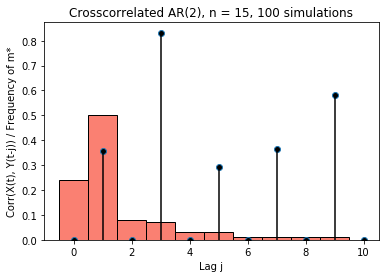

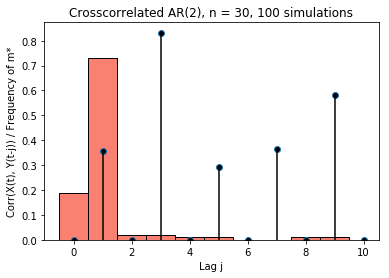

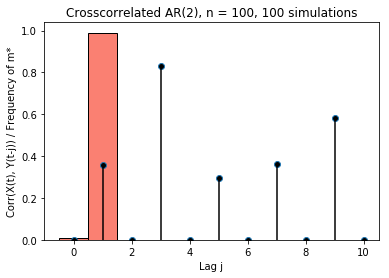

In [15]:
# Correlated AR(2)
phi_1 = 0.1
phi_3 = 0.8
M = 10
num_sims = 100

# Determine true correlations.
rho_XY = np.zeros(M+1)
rho_X = np.zeros(M+1)
rho_X[0] = 1
rho_XY[1] = phi_1 / (1 - phi_3*(phi_1 + phi_3))
rho_X[2] = (phi_1 + phi_3)*rho_XY[1]
for j in range(3, M+1):
    if j%2:
        rho_XY[j] = phi_1*rho_X[j-1] + phi_3*rho_X[j-3]
    else:
        rho_X[j] = phi_1*rho_XY[j-1] + phi_3*rho_XY[j-3]

cdcv = CDCV(max_lag = M)
true_correlations = rho_XY
optimal_lags =  np.zeros(num_sims)

# Run experiments.
for n in [15, 30, 100]:
    for t in range(num_sims):
        X, Y = lin_dep_ar1(n)
        test_statistic, metadata = cdcv.test_statistic(X, Y)
        optimal_lags[t] = metadata['optimal_lag']
    title = "Crosscorrelated AR(2), n = %d, %d simulations" % (n, num_sims)
    opt_lag_distribution(optimal_lags, true_correlations, title, color = 'salmon')